In [44]:
!pip install pydicom pillow pylibjpeg-libjpeg pylibjpeg python-gdcm seaborn matplotlib SciPy scikit-image python-magic tensorflow-io plotly pip install opencv-python tensorflow 

 

     |████████████████████████████████| 244.3 MB 9.9 MB/s eta 0:00:011     |█████████████▍                  | 102.3 MB 11.0 MB/s eta 0:00:13
     |████████████████████████████████| 124 kB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 980 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 65 kB 4.5 MB/s  eta 0:00:01
     |████████████████████████████████| 439 kB 9.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 13.2 MB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 2.9 MB/s  eta 0:00:01
     |████████████████████████████████| 781 kB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 5.8 MB/s eta 0:00:01
     |████████████████████████████████|

     |████████████████████████████████| 155 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 151 kB 8.6 MB/s eta 0:00:01


In [45]:
#%reload_ext signature
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 
import pandas as pd
import cv2
import tensorflow as tf

2022-12-27 13:26:45.035270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [57]:
#test_image = pydicom.read_file('train_images/10006/1459541791.dcm')
u = []
for s in glob("train_images/10006/*.dcm"):
    print("image file %s", s)
    img_test = pydicom.read_file(s)    
    u.append(img_test.pixel_array)
    #plt.imshow(img_test.pixel_array)
    print(img_test)


image file %s train_images/10006/1864590858.dcm
Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1864590858
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1864590858
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.986648'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.84

2022-12-27 13:27:50.551445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 13:27:51.204648: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmItem: Length of element (7fe0,0010) is not a multiple of 2 (VR=OW)
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmItem: Length of element (7fe0,0010) is not a multiple of 2 (VR=OW)
W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmItem: Length of element (7fe0,0010) is not a multiple of 2 (VR=OW)


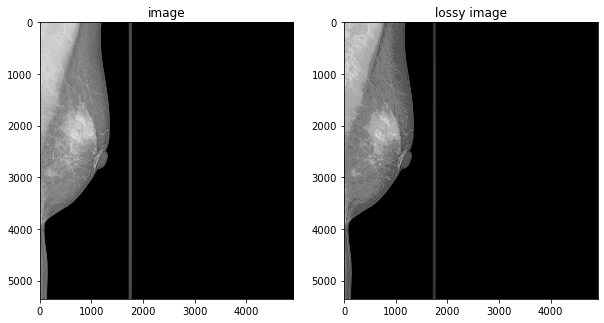

In [46]:
import tensorflow_io as tfio

image_bytes = tf.io.read_file('train_images/10006/1459541791.dcm')

image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
axes[0].set_title('image')
axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
axes[1].set_title('lossy image');

In [49]:
tag_id = tfio.image.dicom_tags.PatientsAge
tag_value = tfio.image.decode_dicom_data(image_bytes,tag_id)
print(tag_value)

tf.Tensor(b'', shape=(), dtype=string)


W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmItem: Length of element (7fe0,0010) is not a multiple of 2 (VR=OW)


In [50]:
tag_id = tfio.image.dicom_tags.PatientsSex
tag_value = tfio.image.decode_dicom_data(image_bytes,tag_id)
print(f"PatientsSex : {tag_value.numpy().decode('UTF-8')}")

PatientsSex : 


W: DcmMetaInfo: No Group Length available in Meta Information Header
W: DcmItem: Length of element (7fe0,0010) is not a multiple of 2 (VR=OW)


In [3]:
ls

rnsa_cnn_init.ipynb               test_images/
rsna-breast-cancer-detection.zip  train.csv
sample_submission.csv             train_images/
test.csv                          workspace/


In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [77]:
train_df["cancer"][train_df["patient_id"] == 10006][0]

0

In [7]:
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


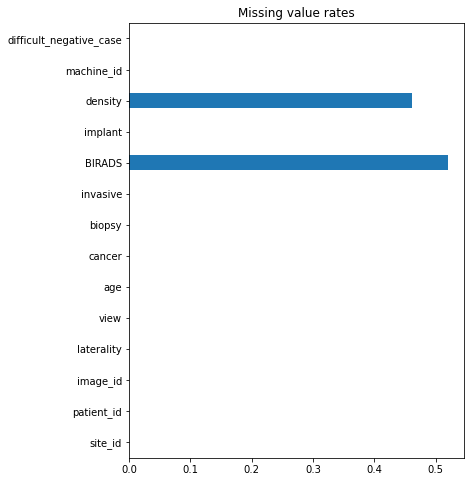

In [8]:
plt.figure(figsize=(6, 8))
train_df.isna().mean().plot(kind="barh")
plt.title("Missing value rates");

In [12]:
test_df.nunique()

site_id          1
patient_id       1
image_id         4
laterality       2
view             2
age              1
implant          1
machine_id       1
prediction_id    2
dtype: int64

In [9]:
train_images = glob("train_images/*/*.dcm")
len(train_images)

54706

In [22]:
train_images[0]

'train_images/1069/1313414003.dcm'

In [10]:
train_image0 = pydicom.read_file(train_images[0])
print(train_image0)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.1069.1.1313414003
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.1069.1.1313414003
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '184021.071147'
(0010, 0020) Patient ID                          LO: '1069'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.1069
(0020, 000e) Series Instance UID

In [11]:
train_image0_array = train_image0.pixel_array

In [25]:
print(train_image0_array)

[[1784 1760 1686 ...    0    0    0]
 [1687 1754 1732 ...    0    0    0]
 [1682 1687 1736 ...    0    0    0]
 ...
 [1040 1043 1044 ...    0    0    0]
 [1034 1041 1059 ...    0    0    0]
 [1070 1059 1070 ...    0    0    0]]


In [28]:
print(train_image0_array.shape)

(2776, 2082)


0
2342


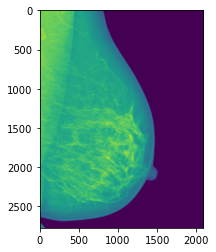

In [12]:
plt.imshow(train_image0_array)
print(train_image0_array.min())
print(train_image0_array.max())

In [13]:
# cf https://towardsdatascience.com/medical-image-pre-processing-with-python-d07694852606
# Five steps of preprocessing: 
# Transforming to HU, Removing Noises, Tilt Correction, Crop Images and Padding.
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [21]:
from scipy import ndimage

In [23]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    window_center = medical_image.WindowCenter[0]
    window_width = medical_image.WindowWidth[0]
    windowed_image = window_image(hu_image, window_center, window_width) 
    
    segmentation = morphology.dilation(windowed_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0

    mask = labels == label_count.argmax()
 
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * windowed_image
    return masked_image

In [46]:
# for tilt correction
# not sure if it is useful for breast cancer as the original data is for brain ct
# tbd

In [27]:
def crop_image(image, display = False):
    mask = image == 0
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis = 1)
    bottom_right = np.max(coords, axis = 1)
    cropped_image = image[top_left[0]:bottom_right[0],
                         top_left[1]:bottom_right[1]]
    return cropped_image

In [28]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

In [37]:
hu_image = transform_to_hu( train_image0, train_image0_array)
windowed_image0 = window_image(hu_image, train_image0.WindowCenter, train_image0.WindowWidth)

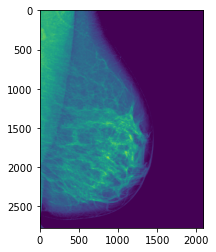

In [38]:
plt.imshow(windowed_image0)

In [26]:
#file_path = "train_images/10006/1459541791.dcm"
removed_noise_image0 = remove_noise("train_images/10006/1459541791.dcm", display = False)

/var/folders/vn/7vh0yxsj5js3z8lj0p09cq1w0000gn/T/ipykernel_85130/595399945.py:13: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [30]:
cropped_image0 = crop_image(removed_noise_image0)

In [36]:
cropped_image0.shape

(5354, 4914)

In [35]:
# added_pad_image0 = add_pad(cropped_image0)

ValueError: could not broadcast input array from shape (5354,4914) into shape (512,512)

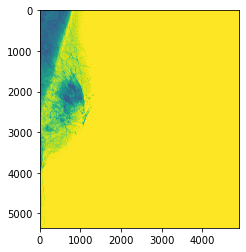

In [31]:
plt.imshow(cropped_image0)

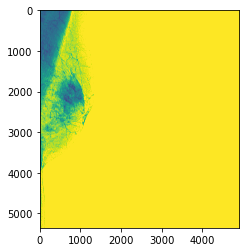

In [32]:
plt.imshow(removed_noise_image0)

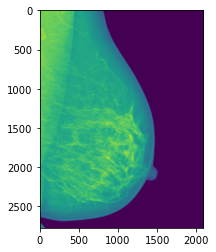

In [34]:
plt.imshow(train_image0_array)

In [61]:
# wrap the above functions up into one master func
def preprocess_dicom(file):
    removed_noise_image0 = remove_noise(file, display = False)
    cropped_image = crop_image(removed_noise_image0)
    return cropped_image

In [79]:
all_patients = os.listdir("train_images/")
y = []
X = []
for patient in all_patients:
    patient_all_files = glob("train_images/"+ patient + "/*.dcm")
    patient_first_file_array = preprocess_dicom(patient_all_files[0])
    X.append(patient_first_file_array)
    y_patient = train_df["cancer"][train_df["patient_id"] == int(patient)][0]
    y.append(y_patient)

TypeError: 'DSfloat' object is not subscriptable

In [87]:
patient = all_patients[0]
patient_all_files = glob("train_images/"+ patient + "/*.dcm")
patient_all_files[0]
y_patient = train_df["cancer"][train_df["patient_id"] == int(patient)][0]
y_patient
#patient_first_file_array = preprocess_dicom(patient_all_files[0])

KeyError: 0